# Run inference on Sentinel-2 and Landsat 8 and postprocess the results

* **Last Modified**: 20-06-2023
* **Authors**: Gonzalo Mateo-García, Enrique Portalés-Julià
---

This notebook shows how to query Sentinel-2 images pre and post flood event using an open source package called **georeader**. After reading the data, the notebook shows how to run inference and vectorize the model outputs to derive prepost event floodmaps. We focus in the region of Nova Kakhovka, Kherson, Ukraine, where recently a dam break caused several flooding. 

**Note**: If you run this notebook in Google Colab you may want to change the running environment to use a GPU.

## Step 1: Install and import the necessary packages 


In [1]:
# # Install the ml4floods package
# !pip install geemap

# !pip install git+https://github.com/spaceml-org/ml4floods#egg=ml4floods

# !pip install git+https://github.com/spaceml-org/georeader#egg=georeader[google]

# # authenticate in GEE
# !earthengine authenticate
a = 1+1

In [2]:
import ee
# ee.Authenticate()
ee.Initialize()
from datetime import datetime, timezone
from georeader.readers import ee_query
from shapely.geometry import shape 
import geopandas as gpd

## Step 2: Define query parameters: area of interest and dates

The area of interest covers the region from Nova Kakhovka to Kherson.  

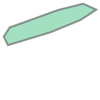

In [3]:


aoi = shape({'type': 'Polygon',
 'coordinates': (((33.40965055141422, 46.849975215311474),
   (33.24671826582107, 46.923511440491325),
   (32.936224664974134, 46.845770100334164),
   (32.33368262768653, 46.62876156455022),
   (32.25990197005967, 46.514641087646424),
   (32.31216326921171, 46.408759851523826),
   (32.843998842939385, 46.56961795883814),
   (33.21905051921081, 46.72367854887557),
   (33.40965055141422, 46.849975215311474)),)})

aoi_gpd = gpd.GeoDataFrame({'geometry':aoi},index = [0]).set_crs('epsg:4326')

aoi

In [4]:

tz = timezone.utc
start_period = datetime.strptime('2023-05-31',"%Y-%m-%d").replace(tzinfo=tz)
end_period = datetime.strptime('2023-06-12',"%Y-%m-%d").replace(tzinfo=tz)

# This function returns a GEE collection of Sentinel-2 and Landsat 8 data and a Geopandas Dataframe with data related to the tiles, overlap percentage and cloud cover
flood_images_gee, flood_collection = ee_query.query(
    area=aoi, 
    date_start=start_period, 
    date_end=end_period,                                                   
    producttype="both", 
    return_collection=True, 
    add_s2cloudless=False)

flood_images_gee.groupby(["solarday","satellite"])[["cloudcoverpercentage","overlappercentage"]].agg(["count","mean"])

cloudcoverpercentage            overlappercentage  \
                                    count       mean             count   
solarday   satellite                                                     
2023-05-31 S2B                          2  75.062169                 2   
2023-06-01 LC08                         2   2.070000                 2   
2023-06-02 LC09                         1  16.040000                 1   
2023-06-03 S2B                          2   4.788626                 2   
2023-06-05 S2A                          2   0.000000                 2   
2023-06-08 S2A                          2  95.540035                 2   
2023-06-09 LC09                         2   7.760000                 2   
2023-06-10 LC08                         1  93.430000                 1   
           S2B                          2  99.942521                 2   

                                 
                           mean  
solarday   satellite             
2023-05-31 S2B        27.434830  
2023-06-01 LC08       78.634958  
2023-06-02 LC09       75.542523  
2023-06-03 S2B        56.100742  
2023-06-05 S2A        27.990063  
2023-06-08 S2A        56.100742  
2023-06-09 LC09       79.054185  
2023-06-10 LC08       67.152296  
           S2B        27.707824

In [5]:
import geemap.foliumap as geemap
import folium

tl = folium.TileLayer(
            tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
            attr='Google',
            name="Google Satellite",
            overlay=True,
            control=True,
            max_zoom=22,
        )

m = geemap.Map(location=aoi.centroid.coords[0][-1::-1], 
               zoom_start=8)

tl.add_to(m)

flood_images_gee["localdatetime_str"] = flood_images_gee["localdatetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
showcolumns = ["geometry","overlappercentage","cloudcoverpercentage", "localdatetime_str","solarday","satellite"]
colors = ["#ff7777", "#fffa69", "#8fff84", "#52adf1", "#ff6ac2","#1b6d52", "#fce5cd","#705334"]
   
# Add the flooding data
for i, ((day,satellite), images_day) in enumerate(flood_images_gee.groupby(["solarday","satellite"])):
    images_day[showcolumns].explore(
        m=m, 
        name=f"{satellite}: {day} outline", 
        color=colors[i % len(colors)], 
        show=False)

# Add the flooding data
for (day, satellite), images_day in flood_images_gee.groupby(["solarday", "satellite"]):    
    image_col_day_sat = flood_collection.filter(ee.Filter.inList("title", images_day.index.tolist()))    
    bands = ["B11","B8","B4"] if satellite.startswith("S2") else ["B6","B5","B4"]
    m.addLayer(image_col_day_sat, 
               {"min":0, "max":3000 if satellite.startswith("S2") else 0.3, "bands": bands},
               f"{satellite}: {day}",
               False)

aoi_gpd.explore(style_kwds={"fillOpacity": 0}, color="black", name="AoI", m=m)
folium.LayerControl(collapsed=False).add_to(m)
m

In [6]:
date_pre = "2023-06-03"
pre_flood = flood_images_gee[flood_images_gee.solarday == date_pre]

date_post = "2023-06-08"
post_flood = flood_images_gee[flood_images_gee.solarday == date_post]
post_flood

,geometry,cloudcoverpercentage,crs_product,gee_id,system:time_start,collection_name,utcdatetime,overlappercentage,solardatetime,solarday,localdatetime,satellite,localdatetime_str
title,,,,,,,,,,,,,
S2A_MSIL1C_20230608T084601_N0509_R107_T36TVS_20230608T104959,"POLYGON ((31.70898 45.95835, 31.70900 45.95835...",91.090149,EPSG:32636,20230608T084601_20230608T084938_T36TVS,1686214645530,COPERNICUS/S2_HARMONIZED,2023-06-08 08:57:25.530000+00:00,83.282631,2023-06-08 11:07:04.427835+00:00,2023-06-08,2023-06-08 08:57:25.530000+00:00,S2A,2023-06-08 08:57:25
S2A_MSIL1C_20230608T084601_N0509_R107_T36TWS_20230608T104959,"POLYGON ((34.44238 46.94462, 34.44228 46.94471...",99.989920,EPSG:32636,20230608T084601_20230608T084938_T36TWS,1686214640951,COPERNICUS/S2_HARMONIZED,2023-06-08 08:57:20.951000+00:00,28.918853,2023-06-08 11:11:50.363462+00:00,2023-06-08,2023-06-08 08:57:20.951000+00:00,S2A,2023-06-08 08:57:20


## Step 3: Read the data 

There are Sentinel-2 cloud free images on 2023-06-03 and 2023-06-05 but only the first one covers the entire AoI. For the postflood data we will use 2023-06-08, which is partially cloudy but allows to see some flood extent. We will read and mosaic the tiles T36TVS and T36TWS using **georeader**. 
Te advantage of this workflow over Google Earth Engine (GEE) is that the images are read directly from the Sentinel-2 public bucket into the jupyter notebook. Also, there is no size limit in the download, which may cause GEE taks to fail sometimes. 

In [7]:
from georeader.readers import S2_SAFE_reader
from georeader.save import save_cog
from georeader import window_utils, mosaic
from georeader.plot import show
from georeader.rasterio_reader import RasterioReader
import os

dir_cache = "cache_s2"
os.makedirs(dir_cache, exist_ok=True)


def mosaic_s2(products, polygon, channels):
    products_read = products.index
    s2objs = []
    for product in products_read:
        s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product+".SAFE", check_exists=False)
        s2obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=channels)
        s2obj = s2obj.cache_product_to_local_dir(dir_cache)
        s2objs.append(s2obj)
    
    polygon_read_dst_crs = window_utils.polygon_to_crs(polygon, 
                                                       crs_polygon="EPSG:4326", dst_crs=s2objs[0].crs)
    
    data_memory = mosaic.spatial_mosaic(s2objs, polygon=polygon_read_dst_crs, dst_crs= s2objs[0].crs)
    
    return data_memory

channels = S2_SAFE_reader.BANDS_S2_L1C
tiff_pre = f"{date_pre}.tif"
if not os.path.exists(tiff_pre):
    pre_flood_memory = mosaic_s2(pre_flood, aoi,channels)
    save_cog(pre_flood_memory, tiff_pre, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    pred_flood = RasterioReader(tiff_pre)
    channels = pred_flood.descriptions
    pre_flood_memory = pred_flood.values

tiff_post = f"{date_post}.tif"
if not os.path.exists(tiff_post):
    post_flood_memory = mosaic_s2(post_flood, aoi,channels)
    save_cog(post_flood_memory, tiff_post, descriptions=S2_SAFE_reader.BANDS_S2_L1C)
else:
    post_flood = RasterioReader(tiff_post)
    channels = post_flood.descriptions
    post_flood_memory = post_flood.values


## Step 3: Run inference

For this we will use an Ml4floods multioutput binary model trained on the WorldFloods data set.

In [8]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/kike/gcpcreds/ml4cc-general-access_request_pays.json"
os.environ['GS_USER_PROJECT'] = 'ml4cc-general'
from ml4floods.scripts.inference import load_inference_function, vectorize_outputv1
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.data import utils
utils.REQUESTER_PAYS_DEFAULT = True

In [9]:
%%time

experiment_name = "WF2_unetv2_bgriswirs"

config_fp = f"gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/{experiment_name}/"


inference_function, config = load_inference_function(config_fp, device_name = 'cuda', max_tile_size=1024,
                                                     th_water=0.6, th_brightness=3500, distinguish_flood_traces=True)

channel_configuration = config['data_params']['channel_configuration']
channels  = get_channel_configuration_bands(channel_configuration, collection_name='S2')

Loaded model weights: gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart/WF2_unetv2_bgriswirs/model.pt
Getting model inference function
CPU times: user 1.87 s, sys: 481 ms, total: 2.35 s
Wall time: 6.93 s


In [10]:
%%time
import torch
import numpy as np
from georeader.geotensor import GeoTensor

def predict(input_tensor, channels = [1, 2, 3, 7, 11, 12] ):
    input_tensor = input_tensor.astype(np.float32)
    input_tensor = input_tensor[channels]
    torch_inputs = torch.tensor(np.nan_to_num(input_tensor))
    return inference_function(torch_inputs)

postflood_pred = f"{date_post}_pred.tif"
if not os.path.exists(postflood_pred):
    prediction_postflood, prediction_postflood_cont  = predict(post_flood_memory)
    prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=post_flood.transform,
                                            fill_value_default=0, crs=post_flood.crs)
    save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"], 
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_postflood_raster = RasterioReader(postflood_pred)

preflood_pred = f"{date_pre}_pred.tif"
if not os.path.exists(preflood_pred):
    prediction_preflood, prediction_preflood_cont = predict(pre_flood_memory)
    # Remove flood traces from pre-flood
    prediction_preflood[prediction_preflood==4] = 1
    
    prediction_preflood_raster = GeoTensor(prediction_preflood.numpy(), transform=pred_flood.transform,
                                           fill_value_default=0, crs=pred_flood.crs)
    
    save_cog(prediction_preflood_raster, preflood_pred, descriptions=["pred"], 
             tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})
else:
    prediction_preflood_raster = RasterioReader(preflood_pred)

CPU times: user 10.2 ms, sys: 41 µs, total: 10.2 ms
Wall time: 10.6 ms


Text(0.5, 1.0, '2023-06-08 floodmap')

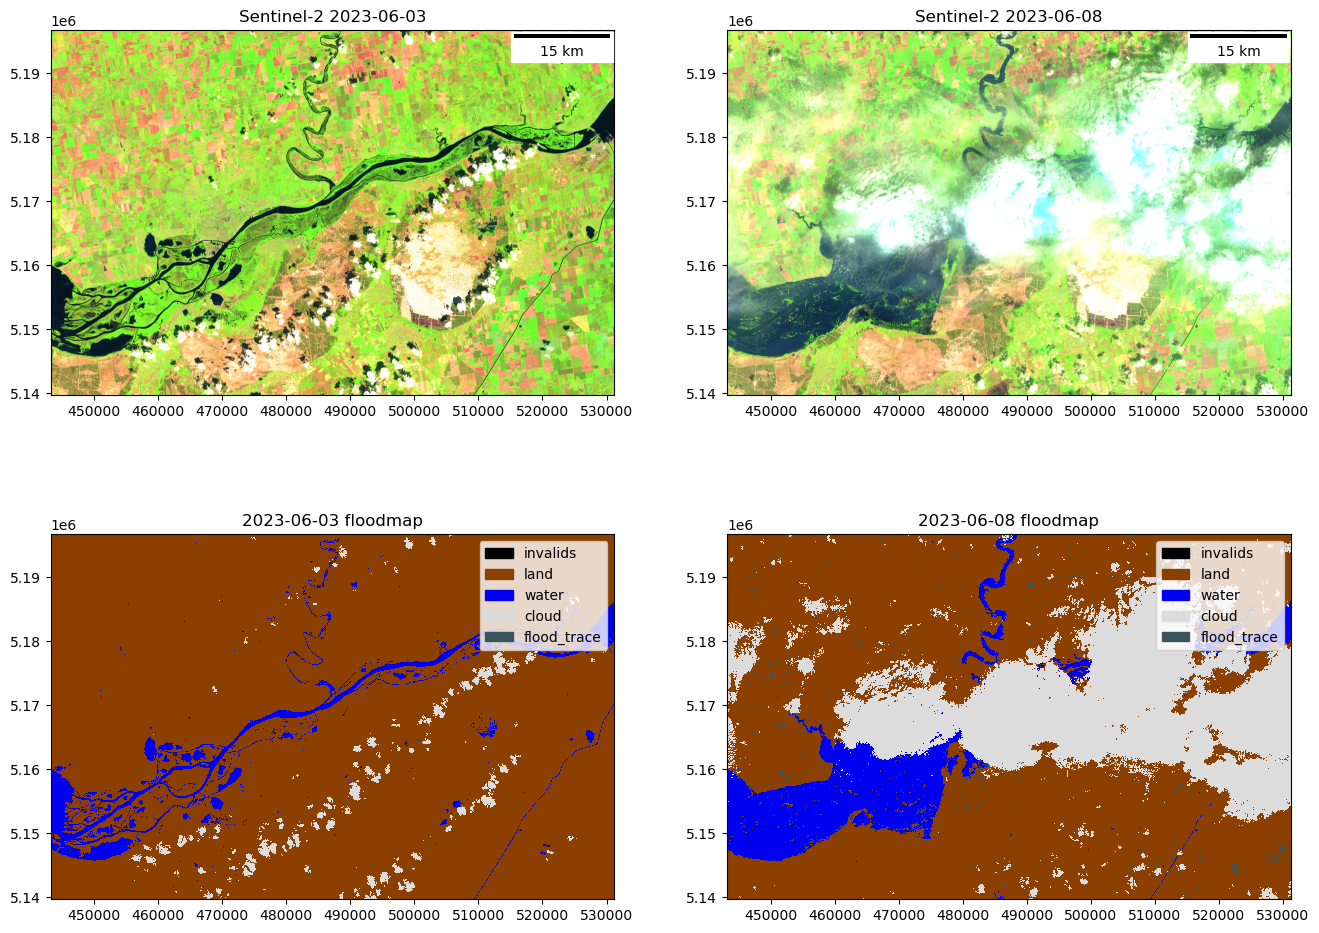

In [11]:
from georeader import plot
import matplotlib.pyplot as plt
from ml4floods.visualization import plot_utils

COLORS_PRED = np.array([[0, 0, 0], # 0: invalid
                       [139, 64, 0], # 1: land
                       [0, 0, 240], # 2: water
                       [220, 220, 220], # 3: cloud
                       [60, 85, 92]], # 5: flood_trace
                    dtype=np.float32) / 255

fig, ax = plt.subplots(2,2,figsize=(16,12),squeeze=False)


plot_utils.plot_swirnirred_image(pre_flood_memory,ax = ax[0,0],transform = pred_flood.transform, add_scalebar = True )
ax[0,0].set_title(f"Sentinel-2 {date_pre}")

plot_utils.plot_swirnirred_image(post_flood_memory,ax = ax[0,1],transform = post_flood.transform, add_scalebar = True )
ax[0,1].set_title(f"Sentinel-2 {date_post}")


plot.plot_segmentation_mask(prediction_preflood_raster, COLORS_PRED, ax=ax[1,0],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])


ax[1,0].set_title(f"{date_pre} floodmap")

plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1,1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"])

ax[1,1].set_title(f"{date_post} floodmap")

## Step 4: Vectorize predictions into prepost flood products



In [12]:
from ml4floods.scripts.inference import vectorize_outputv1

preflood_shape = vectorize_outputv1(prediction_preflood_raster.values[0], 
                                    prediction_preflood_raster.crs, 
                                    prediction_preflood_raster.transform)
postflood_shape = vectorize_outputv1(prediction_postflood_raster.values[0], 
                                     prediction_postflood_raster.crs, 
                                     prediction_postflood_raster.transform)
postflood_shape.shape

(2891, 3)

Text(0.5, 1.0, '2023-06-08 floodmap')

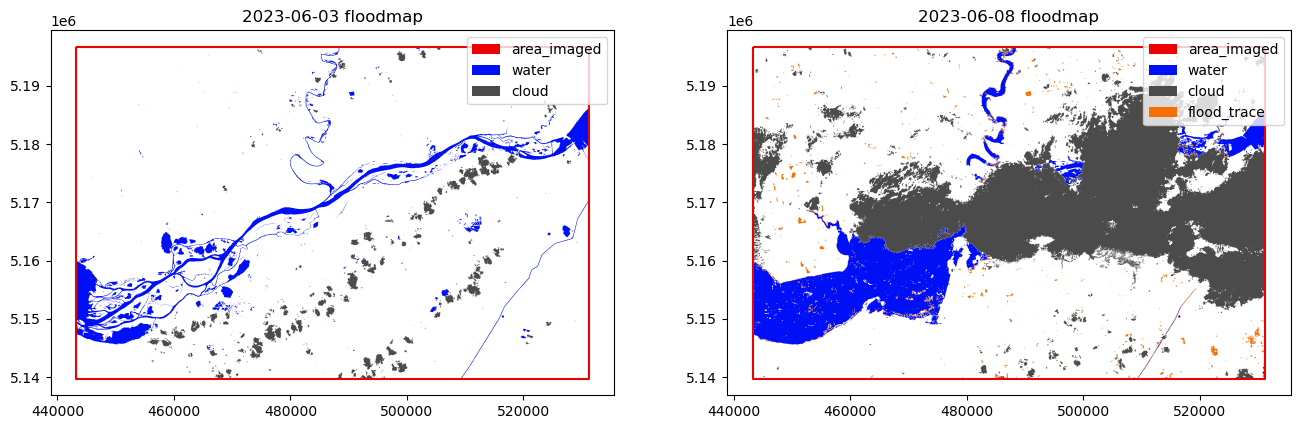

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plot_utils.plot_floodmap(preflood_shape, ax=ax[0])
ax[0].set_title(f"{date_pre} floodmap")
plot_utils.plot_floodmap(postflood_shape, ax=ax[1])
ax[1].set_title(f"{date_post} floodmap")

/home/kike/Projects/ml4floods/ml4floods/models/postprocess.py:181: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if area_missing_or_cloud.type == "GeometryCollection":


<AxesSubplot: >

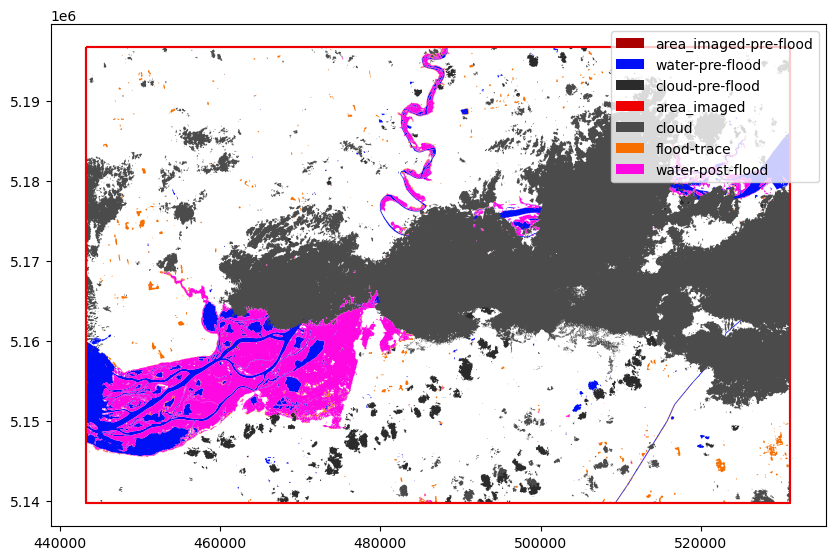

In [14]:
from ml4floods.models import postprocess
prepost_shape = postprocess.compute_pre_post_flood_water(postflood_shape, preflood_shape)
plot_utils.plot_floodmap(prepost_shape)

### Run inference in Landsat 8/9

There is a cloud free Landsat 9 image from the 2023-06-09. Since reading form Landsat public sources is under development in georeader, we downloaded it from Google Earth Engine. We will run inference on it and show how to aggregate several post-flood maps over time. 

In [15]:
post_flood_l9 = RasterioReader('2023-06-09.tif')
post_flood_l9_data = post_flood_l9.values * 10000

In [16]:
postflood_pred = f"2023-06-09_pred.tif"

prediction_postflood, prediction_postflood_cont  = predict(post_flood_l9_data, channels = [1, 2, 3, 4, 5, 6] )
prediction_postflood_raster = GeoTensor(prediction_postflood.numpy(), transform=post_flood_l9.transform,
                                        fill_value_default=0, crs=post_flood_l9.crs)

save_cog(prediction_postflood_raster, postflood_pred, descriptions=["pred"], 
         tags={"0":"invalid", "1": "land", "2":"water", "3":"cloud", "4":"flood_trace"})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/kike/.conda/envs/ml4floods/lib/python3.8/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


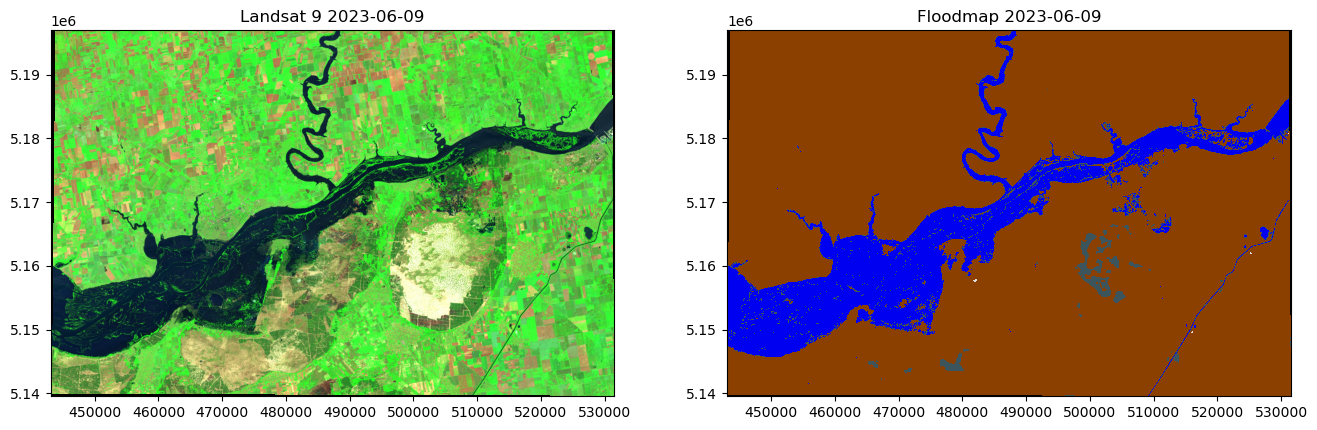

In [17]:
from rasterio.plot import show

data_plot = np.moveaxis(post_flood_l9_data[[6, 4, 3],:,:],0,-1) / 3500


fig, ax = plt.subplots(1,2,figsize=(16,12))

show(post_flood_l9_data[[6, 4, 3],:,:] / 3500,ax = ax[0],transform = post_flood_l9.transform)


ax[0].set_title(f"Landsat 9 2023-06-09")


plot.plot_segmentation_mask(prediction_postflood_raster, COLORS_PRED, ax=ax[1],
                            interpretation_array=["invalids", "land", "water", "cloud", "flood_trace"], legend = False)
ax[1].set_title(f"Floodmap 2023-06-09")

plt.show()


    

In [18]:
post_flood_shape_l9 = vectorize_outputv1(prediction_postflood_raster.values, 
                                    prediction_postflood_raster.crs, 
                                    prediction_postflood_raster.transform)

In [20]:
import warnings
warnings.filterwarnings('ignore')

area_imaged = postflood_shape.loc[postflood_shape['class'] =='area_imaged']

post_flood_shape_l9 = post_flood_shape_l9.loc[post_flood_shape_l9['class'] !='flood_trace']
post_flood_shape = postflood_shape.loc[postflood_shape['class'] !='flood_trace']

postflood_mosaic = postprocess.mosaic_floodmaps([post_flood_shape, post_flood_shape_l9], area_imaged.geometry.values[0], mode = 'max', 
                                                classes_water=['water','flood_trace'])

Text(0.5, 1.0, 'Mosaic floodmap')

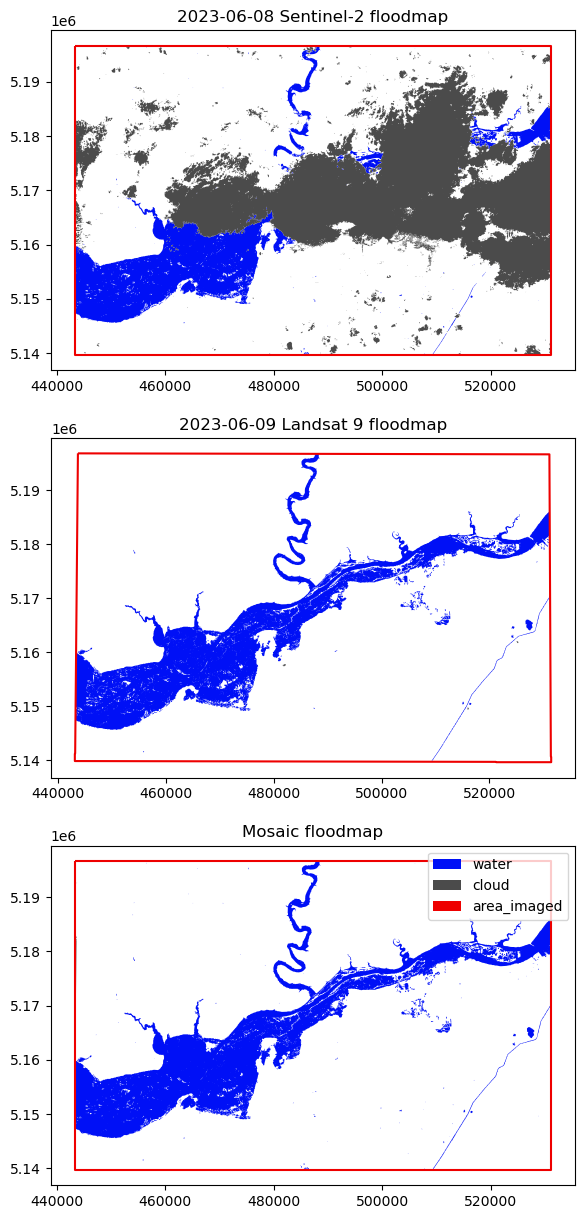

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))
plot_utils.plot_floodmap(post_flood_shape, ax=ax[0], legend = False)
ax[0].set_title(f"{date_post} Sentinel-2 floodmap")
plot_utils.plot_floodmap(post_flood_shape_l9, ax=ax[1], legend = False)
ax[1].set_title(f"2023-06-09 Landsat 9 floodmap")
plot_utils.plot_floodmap(postflood_mosaic,ax = ax[2], legend = True)
ax[2].set_title(f"Mosaic floodmap")


<AxesSubplot: >

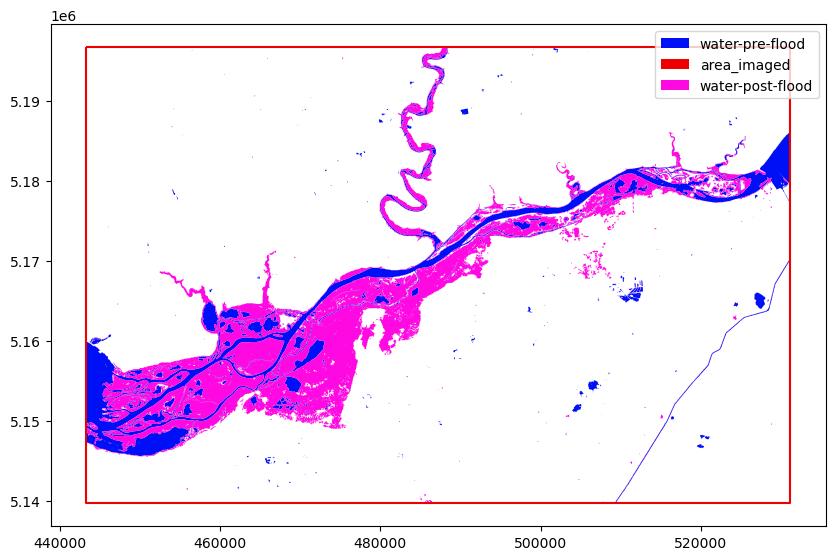

In [22]:
prepost_shape_final = postprocess.compute_pre_post_flood_water(postflood_mosaic, preflood_shape)
prepost_shape_final = prepost_shape_final.loc[prepost_shape_final['class'].isin(['water-pre-flood','water-post-flood','area_imaged'])]
plot_utils.plot_floodmap(prepost_shape_final)

In [ ]:
prepost_shape_final.explore